# Esse notebook tem o único foco de gerar as visões necessárias para o Projeto

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join
import librosa
import noisereduce as nr
import joblib

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [39]:
df = pd.DataFrame([[1,2,3,4,5,6,7,8,9,10]],columns = 'a,b,c,d,h,m,n,x,6,7'.split(','))

for letter in 'a,b,c,d,h,m,n,x,6,7'.split(','):
    t_path = '../treinamento/'+letter
    onlyfiles = [f for f in listdir(t_path) if isfile(join(t_path, f))]
    df[letter]=len(onlyfiles)

In [40]:
df.index=['Número de arquivos']

In [41]:
df

,a,b,c,d,h,m,n,x,6,7
Número de arquivos,136,156,139,140,137,148,136,138,150,144


In [42]:
df.sum(axis=1)/4

Número de arquivos    356.0
dtype: float64

In [19]:
t_path = '../treinamento'
onlyfiles = [f for f in listdir(t_path) if isfile(join(t_path, f))]

In [22]:
len(onlyfiles)*4

1424

In [32]:
df = pd.DataFrame([[1,2,3,4,5,6,7,8,9,10]],columns = 'a,b,c,d,h,m,n,x,6,7'.split(','))

for letter in 'a,b,c,d,h,m,n,x,6,7'.split(','):
    t_path = '../validacao/'+letter
    onlyfiles = [f for f in listdir(t_path) if isfile(join(t_path, f))]
    df[letter]=len(onlyfiles)

In [33]:
df.index=['nmr de arquivos']

In [34]:
df

,a,b,c,d,h,m,n,x,6,7
nmr de arquivos,97,106,107,110,122,104,113,95,100,114


In [37]:
df.sum(axis=1)/4

nmr de arquivos    267.0
dtype: float64

In [51]:
data_test, fs = librosa.load('../treinamento/a/1_3.wav')

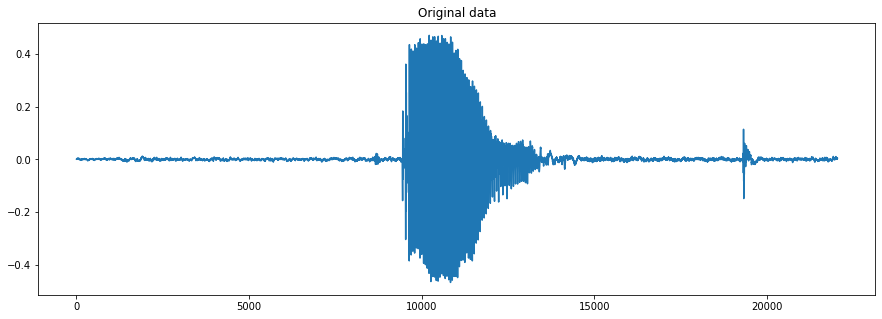

In [66]:
plt.figure(figsize=(15,5))
plt.plot(data_test)
plt.title('Original data')
plt.savefig('../imagens/original_data.png')
plt.show()

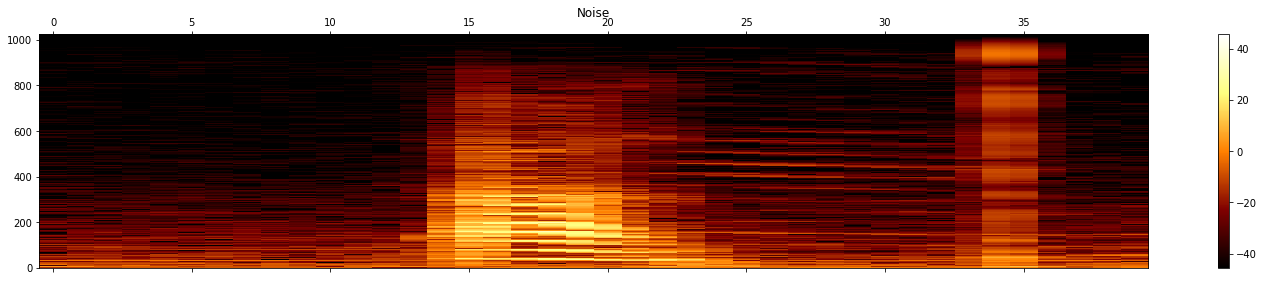

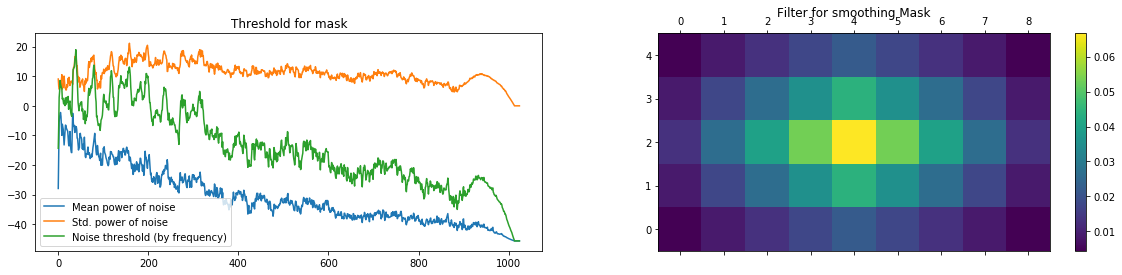

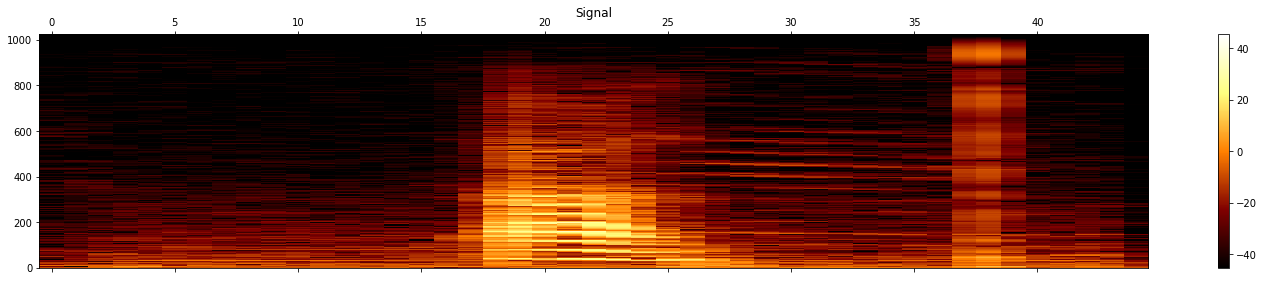

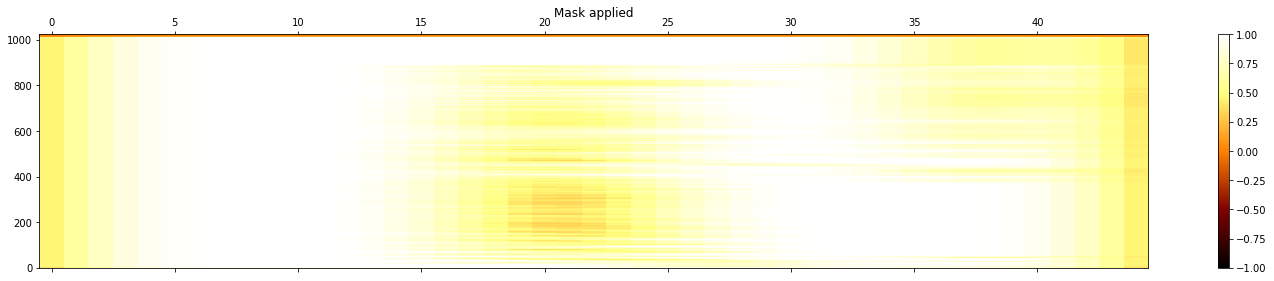

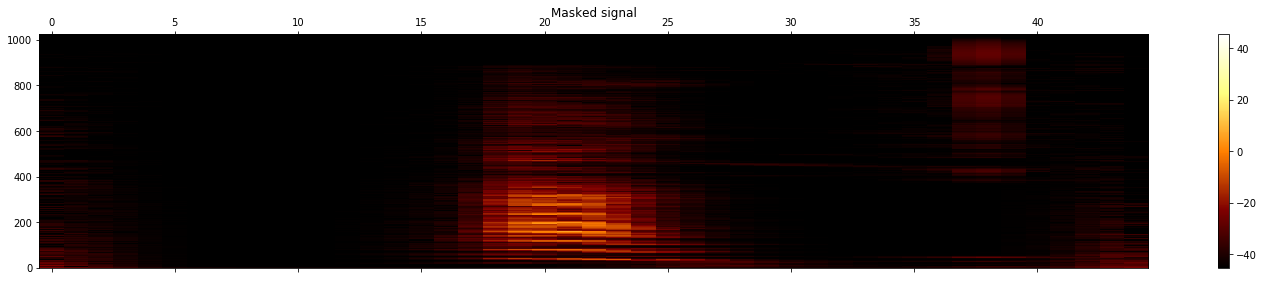

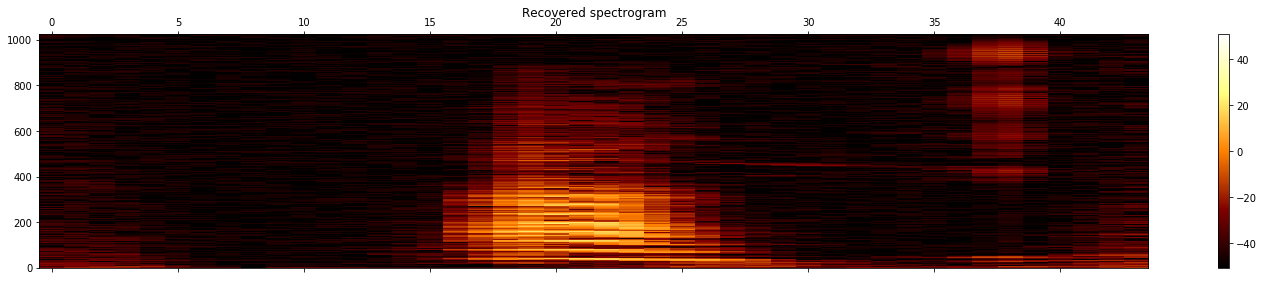

In [56]:
reduced_noise = nr.reduce_noise(audio_clip=data_test, noise_clip=data_test[1750:], verbose=True)

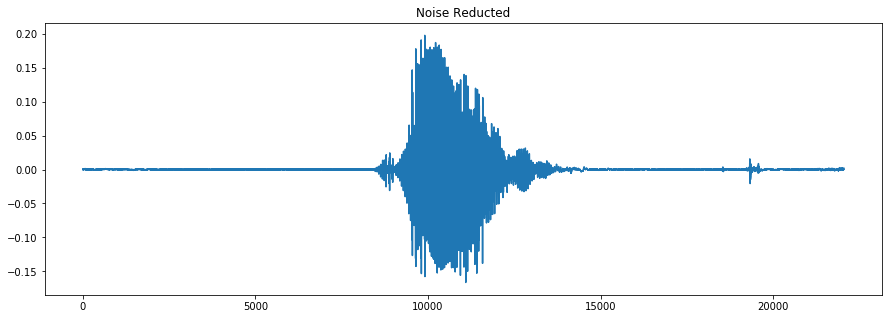

In [70]:
plt.figure(figsize=(15,5))
plt.plot(reduced_noise)
plt.title('Noise Reducted')
plt.savefig('../imagens/noise_reducted.png')
plt.show()

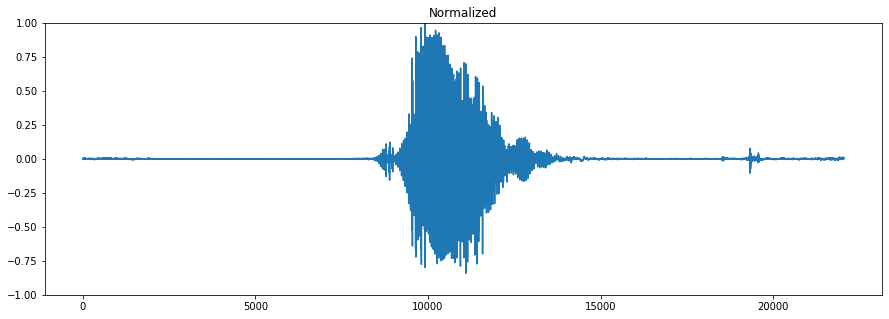

In [71]:
plt.figure(figsize=(15,5))
plt.plot(librosa.util.normalize(reduced_noise))
plt.title('Normalized')
plt.ylim(-1,1)
plt.savefig('../imagens/normalized.png')
plt.show()

In [36]:
t_path = '../validacao'
onlyfiles = [f for f in listdir(t_path) if isfile(join(t_path, f))]
len(onlyfiles)

267

In [88]:
##pd.set_option('max_columns',11)
dados = pd.read_csv('data.csv',index_col=False)
dados.head()

,filename,chroma_stft,chroma_cqt,rmse,spectral_centroid,...,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0_2.wav,0.675671,0.647213,0.032813,4821.223004,...,1.074864,-4.096735,0.139661,0.766718,a
1,100_0.wav,0.641985,0.500162,0.029933,4067.835660,...,1.224929,3.162031,4.524626,7.771187,a
2,101_0.wav,0.602044,0.538624,0.055689,3305.766121,...,1.829411,0.203210,-1.256773,2.162389,a
3,101_2.wav,0.688363,0.725112,0.043488,4474.397443,...,-0.984750,-3.872282,-2.954205,-5.688318,a
4,102_0.wav,0.724626,0.774140,0.033320,4744.066601,...,-3.580620,0.614482,-2.337616,-3.857900,a


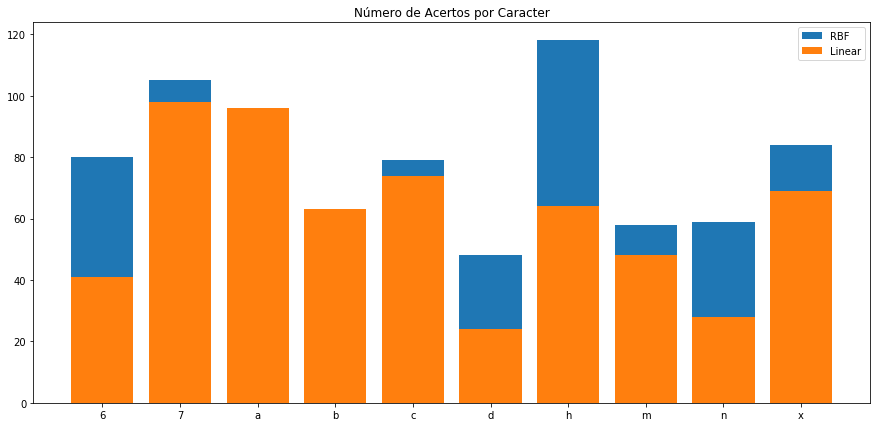

In [197]:
SVM = joblib.load('../models/svcrbf_2.pkl')
SVMlinear = joblib.load('../models/svclinear.pkl')
scaler = joblib.load('../models/scaler_2.pkl')
encoder = joblib.load('../models/encoder_2.pkl')

dado_valid = pd.read_csv('data_validacao.csv',index_col=False)
labels = dado_valid.copy()['label']
dado_valid.head()

dado_valid = dado_valid.drop('filename',axis=1)
dado_valid = dado_valid.drop('label',axis=1)

dado_valid = scaler.transform(dado_valid)

predictions = SVM.predict(dado_valid)

predictions = encoder.inverse_transform(predictions)

predictions_linear = SVMlinear.predict(dado_valid)

predictions_linear = encoder.inverse_transform(predictions_linear)

df = pd.DataFrame(columns=['Real','Predicao_rbf'])
df['Real']=labels
df['Predicao_rbf'] = predictions

df['Predicao_linear'] = predictions_linear

df['Acerto_linear'] = (df['Real']==df['Predicao_linear']).astype(int)
df['Erro_linear'] =  (df['Real']!=df['Predicao_linear']).astype(int)

df['Acerto_rbf'] = (df['Real']==df['Predicao_rbf']).astype(int)
df['Erro_rbf'] =  (df['Real']!=df['Predicao_rbf']).astype(int)

compilado = df[['Real','Acerto_rbf','Erro_rbf','Acerto_linear','Erro_linear']].groupby('Real').sum().transpose()
compilado['Total'] = compilado.sum(axis=1)
compilado['Total(%)'] = compilado['Total']/1068

pd.set_option('max_columns',30)
compilado

plt.figure(figsize=(15,7))
plt.title('Número de Acertos por Caracter')
plt.bar(encoder.classes_,compilado.transpose()['Acerto_rbf'][:-2],label='RBF')
plt.bar(encoder.classes_,compilado.transpose()['Acerto_linear'][:-2],label='Linear')
plt.legend()
plt.savefig('../imagens/nmr_acerto_p_char')
plt.show()